## Dataset

In this homework, I will use the Laptops price dataset from [Kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
```

The goal of this homework is to create a regression model for predicting the prices (column `'Final Price'`).

In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Preparing the dataset 

In [2]:
df = pd.read_csv('laptops.csv')
len(df)

2160

In [3]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


First, I'll normalize the names of the columns:

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

Next, I use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

In [5]:
df_redux = df[['ram', 'storage', 'screen', 'final_price']]
df_redux.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


## EDA

* Look at the `final_price` distribution

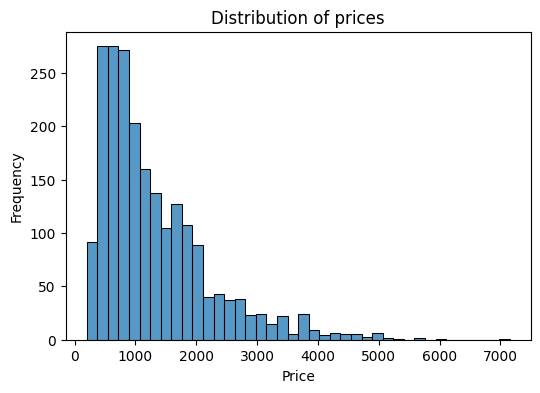

In [6]:
plt.figure(figsize=(6, 4))

sns.histplot(df_redux.final_price, bins=40)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

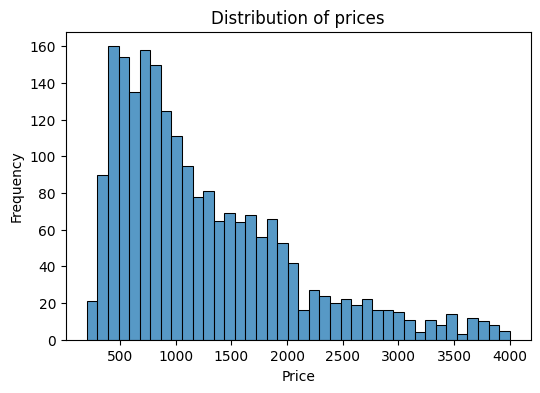

In [7]:
plt.figure(figsize=(6, 4))

sns.histplot(df_redux.final_price[df_redux.final_price < 4000], bins=40)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

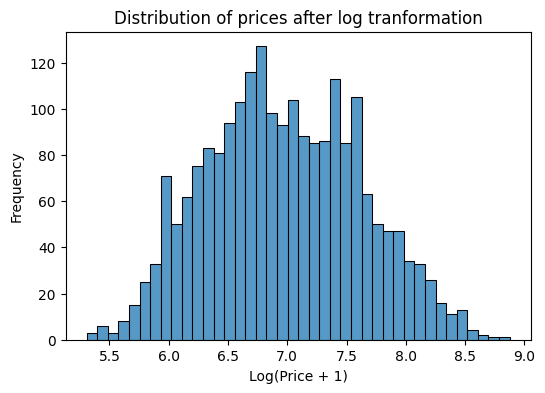

In [8]:
log_price = np.log1p(df_redux.final_price)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

## Question 1

There's one column with missing values. What is it?

* `'ram'`
* `'storage'`
* **`'screen'`**
* `'final_price'`

In [9]:
df_redux.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

## Question 2

What's the median (50% percentile) for variable `'ram'`?

- 8
- **16**
- 24
- 32

In [10]:
print(df_redux['ram'].median())

16.0


## Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [11]:
n = len(df_redux)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [16]:
def prepare_datasets(seed):    
    np.random.seed(seed)
    idx = np.arange(len(df_redux))
    np.random.shuffle(idx)

    df_shuffled = df_redux.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # df_train.fillna(0, inplace=True)
    # df_val.fillna(0, inplace=True)
    # df_test.fillna(0, inplace=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    return df_train, y_train, df_val, y_val, df_test, y_test

In [17]:
 df_train, y_train, df_val, y_val, df_test, y_test = prepare_datasets(42)

In [18]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

## Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- **With 0**
- With mean
- Both are equally good

**Definitions**

In [19]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [20]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    rmse = np.sqrt(mse)
    score = rmse.round(2)
    return score

**Option 1: Fill 'screen' missing values with 0**

In [21]:
df1_train = df_train.copy()
X1_train = df1_train.fillna(0).values
w0, w = train_linear_regression(X1_train, y_train)

df1_val = df_val.copy()
X1_val = df1_val.fillna(0).values
y_pred = w0 + X1_val.dot(w)
print(rmse(y_val, y_pred))

597.36


**Option 2: Fill 'screen' missing values with the mean from df_train**

In [22]:
df2_train = df_train.copy()
X2_train = df2_train.fillna(df_train['screen'].mean()).values
w0, w = train_linear_regression(X2_train, y_train)

df2_val = df_val.copy()
X2_val = df2_val.fillna(df_train['screen'].mean()).values
y_pred = w0 + X2_val.dot(w)
print(rmse(y_val, y_pred))

600.27


## Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- 0
- 0.01
- 1
- **10**
- 100

In [24]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [25]:
for r in [0.0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = df_train.fillna(0).values
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = df_val.fillna(0).values
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print('%6s' %r, w0, score)

   0.0 676.8954853003995 597.36
  0.01 676.2736817205587 597.36
   0.1 670.7284836314063 597.35
     1 619.9030834108207 597.21
     5 463.7771697142356 597.01
    10 352.79713367679835 597.06
   100 66.92071440181994 597.9


## Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- **29.176**
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [26]:
seeds = range(10)
results = []

for seed in seeds:
    df_train, y_train, df_val, y_val, df_test, y_test = prepare_datasets(seed)
    df_train.fillna(0, inplace=True)
    df_val.fillna(0, inplace=True)
    df_test.fillna(0, inplace=True)
    X_train = df_train.values
    w0, w = train_linear_regression(X_train, y_train)

    X_val = df_val.values
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    results.append(score)

std_dev = np.std(results).round(3)

print(f'Standard Deviation of RMSE results: {std_dev}')

Standard Deviation of RMSE results: 29.176


## Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 598.60
- **608.60**
- 618.60
- 628.60


In [27]:
df_train, y_train, df_val, y_val, df_test, y_test = prepare_datasets(9)

In [28]:
df_train.fillna(0, inplace=True)
df_val.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [29]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

In [30]:
y_full_train = np.concatenate([y_train, y_val])

In [31]:
X_full_train = df_full_train.values
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [32]:
X_test = df_test.values
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
print(score)

608.61
